# Loan Approval

**Part 1**

We do the data wrangling

Use column transformer and pipeline to streamline the process

Use Randomised Search to find the optimal set of parameters

Automate the procedure for the multiple classifiers

Plot Precision-Recall Curve

Plot Learning Curve (Check Overfitting)

In [5]:
    pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Ankit\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv("credit_risk_dataset.csv")

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


**Removing duplicates from the data**

In [4]:
dups = df.duplicated()

In [5]:
df[dups]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


Dropping the duplicate instances from the data

In [6]:
X_train , X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'], random_state=0, test_size=.2, stratify=df['loan_status'], shuffle=True) 

In [7]:
df['loan_status'].value_counts(normalize=True)

0    0.781836
1    0.218164
Name: loan_status, dtype: float64

In [9]:
y_train.value_counts(normalize=True)

0    0.781845
1    0.218155
Name: loan_status, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

0    0.781801
1    0.218199
Name: loan_status, dtype: float64

In [11]:
np.round(X_train.isna().sum()*100/ X_train.shape[0], 3)

person_age                    0.000
person_income                 0.000
person_home_ownership         0.000
person_emp_length             2.805
loan_intent                   0.000
loan_grade                    0.000
loan_amnt                     0.000
loan_int_rate                 9.527
loan_percent_income           0.000
cb_person_default_on_file     0.000
cb_person_cred_hist_length    0.000
dtype: float64

In [13]:
X_train.shape

(26064, 11)

In [14]:
X_train.dropna().shape

(22903, 11)

In [15]:
(26064-22903)/26064

0.12127839165131983

It is not Ideal to drop the 12% of data which have missing values

In [17]:
X_train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,26064.000000,2.606400e+04,25333.000000,26064.000000,23581.000000,26064.000000,26064.000000
mean,27.706837,6.625445e+04,4.780681,9629.324931,11.007956,0.170685,5.787523
std,6.372581,6.443824e+04,4.148388,6360.923315,3.248521,0.107218,4.053186
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.866100e+04,2.000000,5000.000000,7.900000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,7.957000e+04,7.000000,12412.500000,13.480000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


Age of 144 and employement length of 123 is unrealistic and hence need to be addrssed before the model building as part of EDA 

In [20]:
num_cols = [col for col in X_train if X_train[col].dtypes != 'O']
num_cols

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

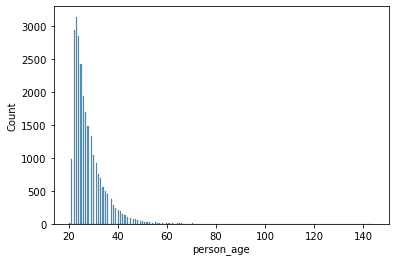

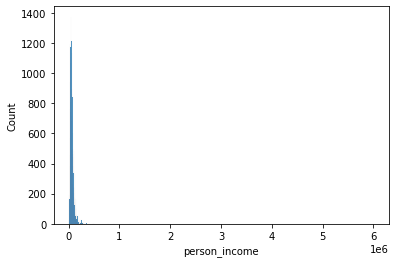

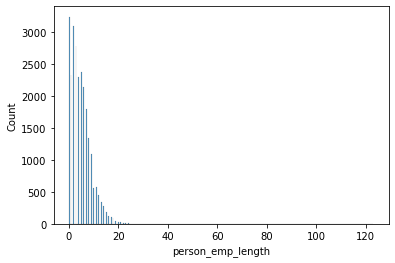

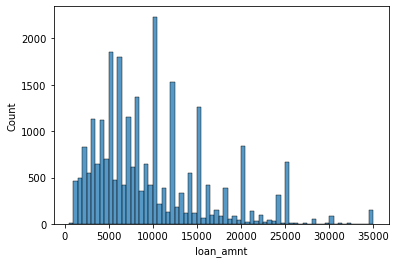

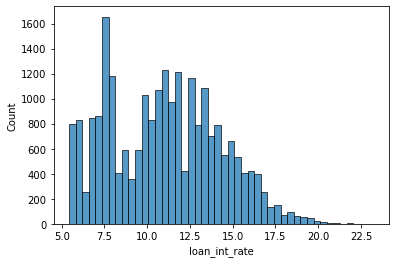

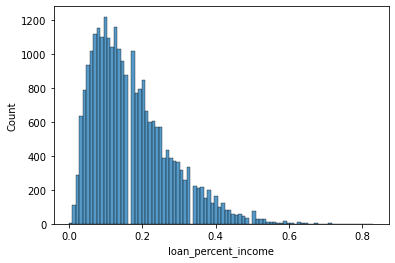

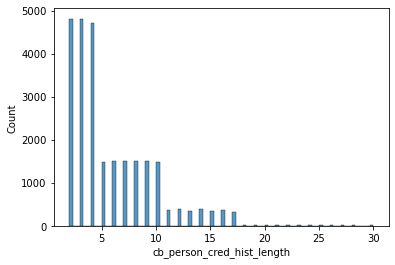

In [22]:
import seaborn as sns
for col in num_cols:
    sns.histplot (X_train[col])
    plt.show()

In [23]:
X_train.loc[X_train['person_age']>=80, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0.27,N,27
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0.03,N,2
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0.26,N,4
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25
32422,80,64000,RENT,7.0,MEDICAL,B,6800,11.71,0.11,N,25
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0.11,N,24


We are assuming that people of age 80 or more usually dont apply for the loan

In [24]:
X_train = X_train.loc[X_train['person_age']<80, :]

We are assuming that 80 is the cutoff of the person applying fo rthe loan. We delete any instance in the dataframe where age is greater than 80.

In [26]:
X_train.shape

(26056, 11)

Since, we are assuming that the cutoff age of loan applicant is 80, therefore we also assume that employement length can not be greater than 66.

In [27]:
X_train.loc[X_train['person_emp_length']>=66, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0.10,N,4
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3


There are just two records so, therefore we can remove them

In [28]:
df.query("person_age<=person_emp_length+14")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4


This is another type of query where we can see that it might be miscalculation (person's employement length)
here person has started to work before legal age 

In [29]:
X_train = X_train.loc[(X_train['person_emp_length']<66) | (X_train['person_emp_length'].isna()),:]

In [30]:
y_train=y_train[X_train.index]

So, now we have passed on the information regarding data that we have deleted from X_train to y_train 

In [31]:
cat_cols = [col for col in X_train if X_train[col].dtypes == 'O']
cat_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

So we have extracted the categorical columns of the dataframe

In [33]:
num_pipe=Pipeline([
    ('impute', IterativeImputer()),
    ('scale', StandardScaler()),
])

We create a pipeline for transforming the numerical columns

In [37]:
ct = ColumnTransformer ([
    ('num_pipe', num_pipe, num_cols),
    ('cat_cols', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)
], remainder = 'passthrough')

We tranform the numerical and categorical variables (categorical variables into One-Hot-Encoder)

In [40]:
grid = {
    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'):
    {'model__n_estimators':[300,400,500],
     'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
    
    LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1):
    {'model__n_estimators':[300,400,500],
     'model__learning_rate':[0.001,0.01,0.1,1,10],
     'model__boosting_type': ['gbdt', 'goss', 'dart'],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
}

So we have created a dictionary of classifier and its parameters

In [41]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}


LGBMClassifier(class_weight='balanced', random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'model__learning_rate': [0.001, 0.01, 0.1, 1, 10], 'model__boosting_type': ['gbdt', 'goss', 'dart'], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}




We have just printed the parameters along with the classifiers

In [42]:
full_df = pd.DataFrame()
best_algos = {}

for clf, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),
    ('model', clf)
])

    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',
                            n_jobs=-1, verbose=3, n_iter=4, random_state=0)
    
    gs.fit(X_train, y_train)
    
    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name
    
    full_df = pd.concat([full_df, temp], ignore_index=True)
    best_algos[algo_name] = gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


We have created two empty containers, full_df and best_algos

Then we create pipeline of column tranformer and classifier

Here we have used randomised search instead of grid search; where we choose random 4 permutations 


In [43]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
3,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.933292,RandomForestClassifier
2,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.933177,RandomForestClassifier
1,"{'model__n_estimators': 500, 'coltf__num_pipe_...",0.932870,RandomForestClassifier
0,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.932755,RandomForestClassifier
7,"{'model__n_estimators': 300, 'model__learning_...",0.921586,LGBMClassifier
5,"{'model__n_estimators': 300, 'model__learning_...",0.910801,LGBMClassifier
6,"{'model__n_estimators': 300, 'model__learning_...",0.908843,LGBMClassifier
4,"{'model__n_estimators': 300, 'model__learning_...",0.903777,LGBMClassifier


In [44]:
be = best_algos['RandomForestClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=0))),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                 

We also find that for the imputor of missing values in the numerical column, the best is ranfom forest regressor

In [45]:
be.fit(X_train, y_train)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=RandomForestRegressor(random_state=0))),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                 

So we fit the best model that we found to the training data

In [46]:
preds = be.predict(X_test)

Then we predict the values of test set

In [47]:
confusion_matrix(y_test, preds)

array([[5074,   21],
       [ 419, 1003]], dtype=int64)

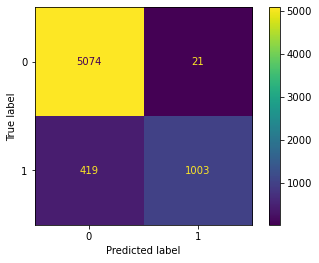

In [48]:
plot_confusion_matrix(be, X_test, y_test)

In [49]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5095
           1       0.98      0.71      0.82      1422

    accuracy                           0.93      6517
   macro avg       0.95      0.85      0.89      6517
weighted avg       0.94      0.93      0.93      6517



In [50]:
be.score(X_test, y_test)

0.9324842719042504

Precision Recall Curve

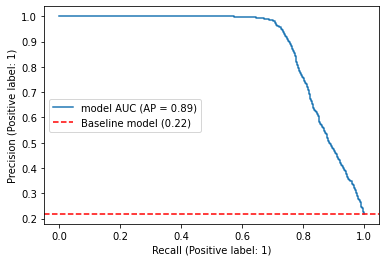

In [51]:
plot_precision_recall_curve(estimator=be, X=X_test, y=y_test, name='model AUC')
baseline = y_test.sum() / len(y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
plt.legend(loc='best')

Area under the curve of the model is .89 and it is good enough as the baseline model is .22

Learning Curve

In [52]:
a, b, c = learning_curve(be, X_train, y_train, n_jobs=-1, scoring='accuracy')

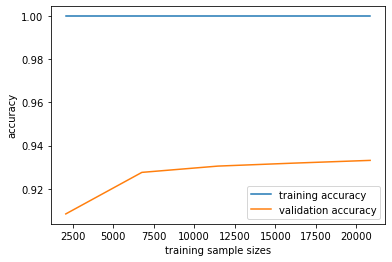

In [53]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()

There is little overfitting on the training data set and also gap between the training and validation data curve shows that the variation of model is high  

We can improve this by using regularization of decision trees in the random forest classifier.